In [1]:
import pandas as pd
import numpy as np

import gc
gc.collect()


0

### Load all seasons

In [2]:
seasons = list(range(2009,2019)) # creates list of years through 2018

# merge seasons into one df
df = pd.DataFrame()
for season in seasons:
    path = './../data/nflscrapR-data/play_by_play_data/regular_season/reg_pbp_'+str(season)+'.csv'
    season_df = pd.read_csv(path)
    season_df['season'] = season
    df = pd.concat([df, season_df], axis=0)
#     path = './../data/nflscrapR-data/play_by_play_data/post_season/post_pbp_'+str(season)+'.csv'
#     post_season_df = pd.read_csv(path)
#     post_season_df['season'] = season
#     df = pd.concat([df, post_season_df], axis=0)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (42,166,167,174,175,178,179,182,183,188,189,190,191,203,204,205,231,232,233,238,240,241) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (37,38,39,42,46,47,166,167,168,169,172,173,174,175,176,177,178,179,182,183,184,185,188,189,190,191,192,193,194,195,198,199,203,204,205,224,225,226,227,231,232,233,238,240,241,244,245,246,250) have mixed types. Speci

### Data Preprocessing

In [3]:
print(len(df))

# standardize jaguars abbrev
df['posteam']=df['posteam'].replace('JAC','JAX')

# drop redzone plays & inside own 5
df = df.loc[(df.yardline_100 > 20) & (df.yardline_100 < 95)]

# drop extreme win probabilities (about 4% of plays)
df = df.loc[(df['wp']>=0.05) | (df['wp']<=0.95)]

# drop afc and nfc

conf_teams = ['AFC','NFC','IRV','APR','NPR','RIC','SANS']
df = df.loc[~df['posteam'].isin(conf_teams)]
print(len(df))



452661
362283


### Load Roster Data

found here: https://github.com/btatkinson/pfr_scraper

In [4]:
path = './../data/roster/roster_info.csv'
roster = pd.read_csv(path)
roster['sea_id'] = roster['season'].astype(str)+roster['player_id']

roster = roster[['id','player_id','season','pos','sea_id','name','age','height','weight','av']]

roster.head(5)

,id,player_id,season,pos,sea_id,name,age,height,weight,av
0,2009PITB.Roethlisberger,00-0022924,2009,QB,200900-0022924,Ben Roethlisberger,27.0,77.0,240.0,14.0
1,2009TENK.Collins,00-0003292,2009,QB,200900-0003292,Kerry Collins,37.0,77.0,247.0,2.0
2,2009CLEB.Quinn,00-0025409,2009,QB,200900-0025409,Brady Quinn,25.0,76.0,232.0,2.0
3,2009MINB.Favre,00-0005106,2009,QB,200900-0005106,Brett Favre,40.0,74.0,222.0,16.0
4,2009NOD.Brees,00-0020531,2009,QB,200900-0020531,Drew Brees,30.0,72.0,209.0,16.0


### QB heatmap

In [5]:
qbs = df.copy()

# drop unnecessary columns
qbs = qbs.drop(columns=['assist_tackle', 'assist_tackle_1_player_id', 'assist_tackle_1_player_name', 'assist_tackle_1_team', 'assist_tackle_2_player_id', 'assist_tackle_2_player_name', 'assist_tackle_2_team', 'assist_tackle_3_player_id', 'assist_tackle_3_player_name', 'assist_tackle_3_team', 'assist_tackle_4_player_id', 'assist_tackle_4_player_name', 'assist_tackle_4_team',
                       'kick_distance', 'kicker_player_id', 'kicker_player_name', 'kickoff_attempt', 'kickoff_downed', 'kickoff_fair_catch', 'kickoff_in_endzone', 'kickoff_inside_twenty', 'kickoff_out_of_bounds', 'kickoff_returner_player_id', 'kickoff_returner_player_name', 'lateral_interception_player_id', 'lateral_interception_player_name', 'lateral_kickoff_returner_player_id', 
                        'lateral_kickoff_returner_player_name', 'lateral_punt_returner_player_id', 'lateral_punt_returner_player_name', 'lateral_receiver_player_id', 'lateral_receiver_player_name', 'lateral_reception', 'lateral_recovery', 'lateral_return', 'lateral_rush', 'lateral_rusher_player_id', 'lateral_rusher_player_name', 'lateral_sack_player_id', 'lateral_sack_player_name',
                         'own_kickoff_recovery','own_kickoff_recovery_player_id','own_kickoff_recovery_player_name','own_kickoff_recovery_td','solo_tackle', 'solo_tackle_1_player_id', 'solo_tackle_1_player_name', 'solo_tackle_1_team', 'solo_tackle_2_player_id', 'solo_tackle_2_player_name', 'solo_tackle_2_team','punt_attempt', 'punt_blocked', 'punt_downed', 'punt_fair_catch', 'punt_in_endzone', 
                        'punt_inside_twenty', 'punt_out_of_bounds', 'punt_returner_player_id', 'punt_returner_player_name', 'punter_player_id', 'punter_player_name','total_away_comp_air_epa', 'total_away_comp_air_wpa', 'total_away_comp_yac_epa', 'total_away_comp_yac_wpa', 'total_away_epa', 'total_away_pass_epa', 'total_away_pass_wpa', 'total_away_raw_air_epa', 'total_away_raw_air_wpa', 'total_away_raw_yac_epa', 
                        'total_away_raw_yac_wpa', 'total_away_rush_epa', 'total_away_rush_wpa', 'total_away_score', 'total_home_comp_air_epa', 'total_home_comp_air_wpa', 'total_home_comp_yac_epa', 'total_home_comp_yac_wpa', 'total_home_epa', 'total_home_pass_epa', 'total_home_pass_wpa', 'total_home_raw_air_epa', 'total_home_raw_air_wpa', 'total_home_raw_yac_epa', 'total_home_raw_yac_wpa', 'total_home_rush_epa', 
                        'total_home_rush_wpa', 'total_home_score', 'touchback', 'two_point_attempt', 'two_point_conv_result'])

qb_ids = roster.loc[roster.pos=='QB']
qb_ids = list(qb_ids.player_id.values)

print(len(qbs))
qbs = qbs.loc[(qbs['passer_player_id'].isin(qb_ids)) | qbs['rusher_player_id'].isin(qb_ids)]
print(len(qbs))


qbs['season'] = qbs['season'].astype(str)

qb_rushes = qbs.loc[qbs.play_type=='run']
qb_passes = qbs.loc[qbs.play_type=='pass']

qb_rushes['id'] = qb_rushes['season'] + qb_rushes['posteam'] + qb_rushes['rusher_player_name']
qb_passes['id'] = qb_passes['season'] + qb_passes['posteam'] + qb_passes['passer_player_name']


qb_rushes = pd.merge(how='left',left=qb_rushes,right=roster,on=['id'])
qb_passes = pd.merge(how='left',left=qb_passes,right=roster,on=['id'])
print(qb_rushes.shape)
print(qb_passes.shape)

qb_rushes = qb_rushes.drop(columns=['season_y'])
qb_passes = qb_passes.drop(columns=['season_y'])

qb_rushes = qb_rushes.rename(columns={'season_x':'season'})
qb_passes = qb_passes.rename(columns={'season_x':'season'})




362283
175442


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(9731, 174)
(161204, 174)


In [6]:
# only take QBs that matched roster ids. About 94% of pass plays
qb_passes = qb_passes.loc[qb_passes['player_id']==qb_passes['passer_player_id']]
qb_rushes = qb_rushes.loc[qb_rushes['player_id']==qb_rushes['rusher_player_id']]
print(qb_passes.shape)
print(qb_rushes.shape)

(151749, 173)
(9250, 173)


In [7]:
qb_passes['sea_id'] = qb_passes['season'].astype(str) + qb_passes['passer_player_id']
qb_rushes['sea_id'] = qb_rushes['season'].astype(str) + qb_rushes['rusher_player_id']

In [8]:
# only take qbs with at least 3 rushes and 100 passes
gb = qb_rushes.groupby(['sea_id'])['epa'].count()
gb = gb.loc[gb >= 3].reset_index()
run_ids = list(gb['sea_id'].unique())

gb = qb_passes.groupby(['sea_id'])['epa'].count()
gb = gb.loc[gb >= 100].reset_index()
pass_ids = list(gb['sea_id'].unique())

qb_ids = []
for pid in pass_ids:
    if pid in run_ids:
        qb_ids.append(pid)

print(str(len(qb_ids)) + " Quarterbacks meet the criteria")

388 Quarterbacks meet the criteria


In [9]:
def explosiveness(x):
    # (Warning: O(n**2) in time and memory, where n = len(x).  *Don't* pass in huge samples!)
    
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    mean = np.mean(x)
    
    if mean == 0:
        return 0
    rmad = mad/mean
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [10]:
# get game count
gc = qb_passes.groupby(['sea_id'])['game_id'].nunique()

# only use qbs with over 5 games

gc = gc.loc[gc > 5]
gc = gc.reset_index()
print(gc.head())

qb_passes = qb_passes.loc[qb_passes['sea_id'].isin(list(gc.sea_id.values))]
qb_rushes = qb_rushes.loc[qb_rushes['sea_id'].isin(list(gc.sea_id.values))]

           sea_id  game_id
0  200900-0003292        7
1  200900-0003739        8
2  200900-0004161       11
3  200900-0005106       16
4  200900-0007091       14


In [11]:
# yards per rush
ypc = qb_rushes.groupby(['sea_id'])['yards_gained'].mean().reset_index()
ypc = ypc.rename(columns={'yards_gained':'YPC'})

# win probability added on rushes (will do per game later)
wpa = qb_rushes.groupby(['sea_id'])['wpa'].sum().reset_index()

# attempts (will do per game later)
att = qb_rushes.groupby(['sea_id'])['yards_gained'].count().reset_index()
att = att.rename(columns={'yards_gained':'Att'})

# run explosiveness
rexp = qb_rushes.groupby(['sea_id'])['yards_gained'].apply(explosiveness).reset_index()
rexp = rexp.rename(columns={'yards_gained':'Run_Exp'})

In [12]:
# merge in rushing stats
qb_run_dfs = [ypc,wpa,att,rexp]
for rdf in qb_run_dfs:
    gc = pd.merge(how='left',left=gc,right=rdf,on=['sea_id'])

In [13]:
gc['Run Att/G'] = gc['Att']/gc['game_id']
gc['Run WPA/G'] = gc['wpa']/gc['game_id']

gc = gc.drop(columns=['Att','wpa'])

In [14]:
print(list(qb_passes))

['air_epa', 'air_wpa', 'air_yards', 'away_team', 'away_timeouts_remaining', 'away_wp', 'away_wp_post', 'blocked_player_id', 'blocked_player_name', 'comp_air_epa', 'comp_air_wpa', 'comp_yac_epa', 'comp_yac_wpa', 'complete_pass', 'def_wp', 'defensive_extra_point_attempt', 'defensive_extra_point_conv', 'defensive_two_point_attempt', 'defensive_two_point_conv', 'defteam', 'defteam_score', 'defteam_score_post', 'defteam_timeouts_remaining', 'desc', 'down', 'drive', 'ep', 'epa', 'extra_point_attempt', 'extra_point_prob', 'extra_point_result', 'fg_prob', 'field_goal_attempt', 'field_goal_result', 'first_down_pass', 'first_down_penalty', 'first_down_rush', 'forced_fumble_player_1_player_id', 'forced_fumble_player_1_player_name', 'forced_fumble_player_1_team', 'forced_fumble_player_2_player_id', 'forced_fumble_player_2_player_name', 'forced_fumble_player_2_team', 'fourth_down_converted', 'fourth_down_failed', 'fumble', 'fumble_forced', 'fumble_lost', 'fumble_not_forced', 'fumble_out_of_bounds',

In [15]:
def is_success(epa):
    return 1 if epa >= 0 else 0

# add success column
qb_passes['success'] = qb_passes.apply(lambda row: is_success(row['epa']),axis=1)

In [16]:
# total dropbacks
dbs = qb_passes.groupby(['sea_id'])['epa'].count().reset_index()
dbs = dbs.rename(columns={'epa':'dropbacks'})

# average columns to get per dropback numbers
means = qb_passes.groupby(['sea_id'])['touchdown','interception','complete_pass','qb_hit','sack','success','epa','wp'].mean().reset_index()

means = means.rename(columns={'touchdown':'TD/D','interception':'INT/D','complete_pass':'Comp/D','qb_hit':'Hit/D',
                              'sack':'Sack/D','success':'SR/D','epa':'EPA/D','wp':'Avg_WP'})

means['Incomp/D'] = 1-means['TD/D'] - means['INT/D'] - means['Comp/D'] - means['Sack/D']

means.tail(15)



,sea_id,TD/D,INT/D,Comp/D,Hit/D,Sack/D,SR/D,EPA/D,Avg_WP,Incomp/D
358,201800-0031503,0.017241,0.031609,0.609195,0.149425,0.068966,0.500000,0.063832,0.443823,0.272989
359,201800-0032268,0.012579,0.022013,0.628931,0.160377,0.119497,0.474843,0.032629,0.455222,0.216981
360,201800-0032436,0.011834,0.011834,0.573964,0.165680,0.082840,0.372781,-0.104464,0.331076,0.319527
361,201800-0032950,0.010899,0.016349,0.664850,0.174387,0.073569,0.509537,0.090963,0.477000,0.234332
362,201800-0033077,0.022044,0.012024,0.635271,0.176353,0.094188,0.466934,0.078369,0.493865,0.236473
363,201800-0033106,0.020704,0.020704,0.627329,0.118012,0.057971,0.538302,0.207121,0.546386,0.273292
364,201800-0033319,0.024590,0.028689,0.618852,0.229508,0.057377,0.495902,0.181702,0.414823,0.270492
365,201800-0033537,0.012848,0.019272,0.642398,0.216274,0.100642,0.498929,0.090199,0.543441,0.224839
366,201800-0033869,0.015464,0.028351,0.636598,0.095361,0.054124,0.481959,0.067629,0.622450,0.265464
367,201800-0033873,0.034908,0.020534,0.644764,0.154004,0.039014,0.533881,0.314948,0.629086,0.260780


In [17]:
# divide into completions and incompletions and sacks
qb_comps = qb_passes.loc[qb_passes.complete_pass==1]
qb_incomps = qb_passes.loc[(qb_passes.complete_pass==0) & (qb_passes.sack==0)]
qb_sacks = qb_passes.loc[(qb_passes.complete_pass==0) & (qb_passes.sack==1)]

pass_avgs = qb_comps.groupby(['sea_id'])['yards_gained','yards_after_catch','air_yards'].mean().reset_index()
pass_avgs = pass_avgs.rename(columns={'yards_gained':'YPComp','yards_after_catch':'YAC','air_yards':'aDOT'})

# have to calc expl separately
expl_compl = qb_comps.groupby(['sea_id'])['yards_gained'].apply(explosiveness).reset_index()
expl_yac = qb_comps.groupby(['sea_id'])['yards_after_catch'].apply(explosiveness).reset_index()
expl_ay = qb_comps.groupby(['sea_id'])['air_yards'].apply(explosiveness).reset_index()

expl_compl = expl_compl.rename(columns={'yards_gained':'YPComp_Expl'})
expl_yac = expl_yac.rename(columns={'yards_after_catch':'YAC_Expl'})
expl_ay = expl_ay.rename(columns={'air_yards':'AY_Expl'})

icay = qb_incomps.groupby(['sea_id'])['air_yards'].mean().reset_index()
icay = icay.rename(columns={'air_yards':'ICAY'})


In [18]:
# merge in pass dataframes
qb_pass_dfs = [dbs,means,pass_avgs,expl_compl,expl_yac,expl_ay,icay]
for pdf in qb_pass_dfs:
    gc = pd.merge(how='left',left=gc,right=pdf,on=['sea_id'])

gc['Dropbacks/G'] = gc['dropbacks']/gc['game_id']
gc1 = gc[gc.isna().any(axis=1)]
print(gc1)
gc = gc.drop(columns=['game_id','dropbacks'])
gc.head()

             sea_id  game_id       YPC   Run_Exp  Run Att/G  Run WPA/G  \
2    200900-0004161       11  7.100000  0.283099   0.909091   0.015044   
6    200900-0011022       14  7.470588  0.510421   1.214286   0.028833   
8    200900-0019596       16  3.916667  0.342199   0.750000   0.007776   
16   200900-0022787       16  3.750000  0.516667   1.250000  -0.010610   
17   200900-0022803       16  6.545455  0.426768   0.687500  -0.043701   
18   200900-0022924       15  4.823529  0.542324   1.133333   0.012146   
43   201000-0009311       10  7.263158  0.482075   1.900000   0.009799   
52   201000-0022787       16  2.916667  0.511905   0.750000  -0.008673   
55   201000-0023436       11  6.000000  0.432099   0.818182  -0.001607   
58   201000-0023541       13  6.058824  0.358652   1.307692   0.008202   
60   201000-0023662       15  5.608696  0.471857   1.533333  -0.006276   
62   201000-0024218        9  7.529412  0.468750   1.888889   0.013520   
65   201000-0025423        6  9.857143

,sea_id,YPC,Run_Exp,Run Att/G,Run WPA/G,TD/D,INT/D,Comp/D,Hit/D,Sack/D,...,Avg_WP,Incomp/D,YPComp,YAC,aDOT,YPComp_Expl,YAC_Expl,AY_Expl,ICAY,Dropbacks/G
0,200900-0003292,1.500000,0.500000,0.571429,-0.044341,0.005155,0.041237,0.546392,0.082474,0.025773,...,0.347261,0.381443,10.981132,5.179245,5.801887,0.436313,0.652971,0.639254,11.759036,27.714286
1,200900-0003739,5.733333,0.617054,1.875000,0.000009,0.006329,0.037975,0.537975,0.145570,0.088608,...,0.177841,0.329114,10.647059,4.411765,6.235294,0.357153,0.594635,0.583263,11.491525,19.625000
2,200900-0004161,7.100000,0.283099,0.909091,0.015044,0.022876,0.055556,0.542484,0.114379,0.065359,...,0.367003,0.313725,11.626506,4.890909,6.753012,0.381216,NaN,0.616054,13.841667,27.454545
3,200900-0005106,2.250000,0.416667,0.250000,-0.009162,0.012903,0.010753,0.636559,0.135484,0.062366,...,0.580960,0.277419,12.672297,5.959459,6.712838,0.423003,0.570927,0.687151,12.807143,29.062500
4,200900-0007091,5.666667,0.566449,1.285714,-0.006464,0.015766,0.029279,0.569820,0.139640,0.065315,...,0.356889,0.319820,10.830040,6.351779,4.478261,0.430299,0.577538,0.882110,11.135802,31.714286


In [19]:
# merge in roster
roster_merge = roster[['sea_id','age','height','weight','av']]
gc = pd.merge(how='left',left=gc,right=roster_merge,on=['sea_id'])


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# change gc column order
print(len(list(gc)))
cols = ['sea_id','age','height','weight','av',
        'Dropbacks/G','EPA/D','SR/D','Comp/D','Incomp/D','TD/D','INT/D','Sack/D','Hit/D','Avg_WP',
        'YPComp','aDOT','YAC','YPComp_Expl','YAC_Expl','AY_Expl','ICAY','YPC','Run_Exp','Run Att/G',
        'Run WPA/G']
gc = gc[cols]
print(len(list(gc)))

fig, ax = plt.subplots(figsize=(16, 11))

#saleprice correlation matrix
sns.heatmap(gc.corr(),
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            annot_kws={'size':10},
            cbar=True,
            square=False)

plt.show()

fig.savefig('./plots/QB_Heatmap.png', bbox_inches='tight')

26
26


<Figure size 1600x1100 with 2 Axes>

### PCA!

In [21]:
# follows https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

# drop nans (32 QBs) - not sure what's wrong, but most are from '09/10 and I'm okay with excluding them
gc = gc.dropna()

# drop duplicates - not sure how these got here
gc = gc.drop_duplicates(subset='sea_id')


from sklearn.preprocessing import StandardScaler

features = cols[1:]
labels = cols[:1]

# Separating out the features
x = gc.loc[:, features].values
labels = gc.loc[:,labels]


roster_names = roster[['sea_id','age','season','name']]
roster_names = roster_names.drop_duplicates()

labels = pd.merge(how='left',left=labels, right=roster_names, on=['sea_id'])

labels['label'] = labels['season'].astype(str) + '_' + labels['name']

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
pca_df = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3'])

pca_df = pd.concat([labels,pca_df],axis=1)

# lead_pc1 = ['2011_Aaron Rodgers','2011_Drew Brees']
# lead_pc2 = ['2013_Michael Vick', '2017_Deshaun Watson']
# lead_pc3 = ['2014_Robert Griffin','2017_Drew Brees']

pca_df = pca_df.sort_values(by='pc1',ascending=True).reset_index()

# ar11 = pca_df[pca_df['label']=='2011_Aaron Rodgers'].index.values.astype(int)[0]
# db11 = pca_df[pca_df['label']=='2011_Drew Brees'].index.values.astype(int)[0]
# mv13 = pca_df[pca_df['label']=='2013_Michael Vick'].index.values.astype(int)[0]
# dw17 = pca_df[pca_df['label']=='2017_Deshaun Watson'].index.values.astype(int)[0]
# rg14 = pca_df[pca_df['label']=='2014_Robert Griffin'].index.values.astype(int)[0]
# db17 = pca_df[pca_df['label']=='2017_Drew Brees'].index.values.astype(int)[0]

# print([ar11,db11,mv13,dw17,rg14,db17])

pca_df.head(5)

,index,sea_id,age,season,name,label,pc1,pc2,pc3
0,71,201100-0023459,28.0,2011,Aaron Rodgers,2011_Aaron Rodgers,-5.803916,2.112885,1.211841
1,64,201100-0020531,32.0,2011,Drew Brees,2011_Drew Brees,-5.653226,-0.762894,-1.173078
2,241,201600-0026143,31.0,2016,Matt Ryan,2016_Matt Ryan,-5.410802,1.185678,1.206685
3,305,201800-0020531,39.0,2018,Drew Brees,2018_Drew Brees,-5.285427,-1.341385,-1.188075
4,6,200900-0020531,30.0,2009,Drew Brees,2009_Drew Brees,-5.190640,0.385861,-0.203017


### Plot in 3d

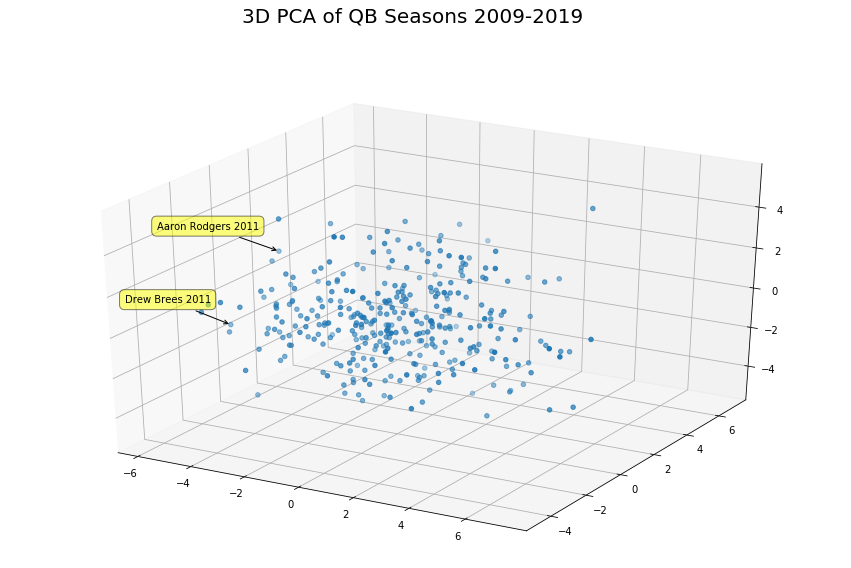

In [23]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = pylab.figure(figsize=(15,9))
ax = fig.add_subplot(111, projection = '3d')

x = pca_df.pc1
y = pca_df.pc2
z = pca_df.pc3

sc = ax.scatter(x,y,z)
# now try to get the display coordinates of the first point

x1, y1, _1 = proj3d.proj_transform(-5.6522,-0.762894,-1.17307, ax.get_proj())
x2, y2, _2 = proj3d.proj_transform(-5.8039,2.1129,1.211841, ax.get_proj())

label1 = pylab.annotate(
    "Drew Brees 2011", 
    xy = (x1, y1), xytext = (-20, 20),
    textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

label2 = pylab.annotate(
    "Aaron Rodgers 2011", 
    xy = (x2, y2), xytext = (-20, 20),
    textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))


def update_position1(e):
    x1, y1, _1 = proj3d.proj_transform(1,1,1, ax.get_proj())
    label1.xy = x1,y1
    label1.update_positions(fig.canvas.renderer)
    
def update_position2(e):
    x2, y2, _2 = proj3d.proj_transform(1,1,1, ax.get_proj())
    label2.xy = x2,y2
    label2.update_positions(fig.canvas.renderer)
    fig.canvas.draw()

fig.canvas.mpl_connect('button_release_event', update_position1)
fig.canvas.mpl_connect('button_release_event', update_position2)

fig.suptitle("3D PCA of QB Seasons 2009-2019", fontsize=20)

pylab.show()

fig.savefig('./plots/QB_3D.png', bbox_inches='tight')

### 2D is better...

In [24]:
x = gc.loc[:, features].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
pca_df = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])

pca_df = pd.concat([labels,pca_df],axis=1)

pca_df.head(5)

,sea_id,age,season,name,label,pc1,pc2
0,200900-0003292,37.0,2009,Kerry Collins,2009_Kerry Collins,2.656268,-4.523517
1,200900-0003739,32.0,2009,Daunte Culpepper,2009_Daunte Culpepper,4.510068,-1.750384
2,200900-0005106,40.0,2009,Brett Favre,2009_Brett Favre,-3.197700,-1.456211
3,200900-0007091,34.0,2009,Matt Hasselbeck,2009_Matt Hasselbeck,1.811066,-1.317382
4,200900-0010346,33.0,2009,Peyton Manning,2009_Peyton Manning,-4.926029,-2.834333


(341, 2)


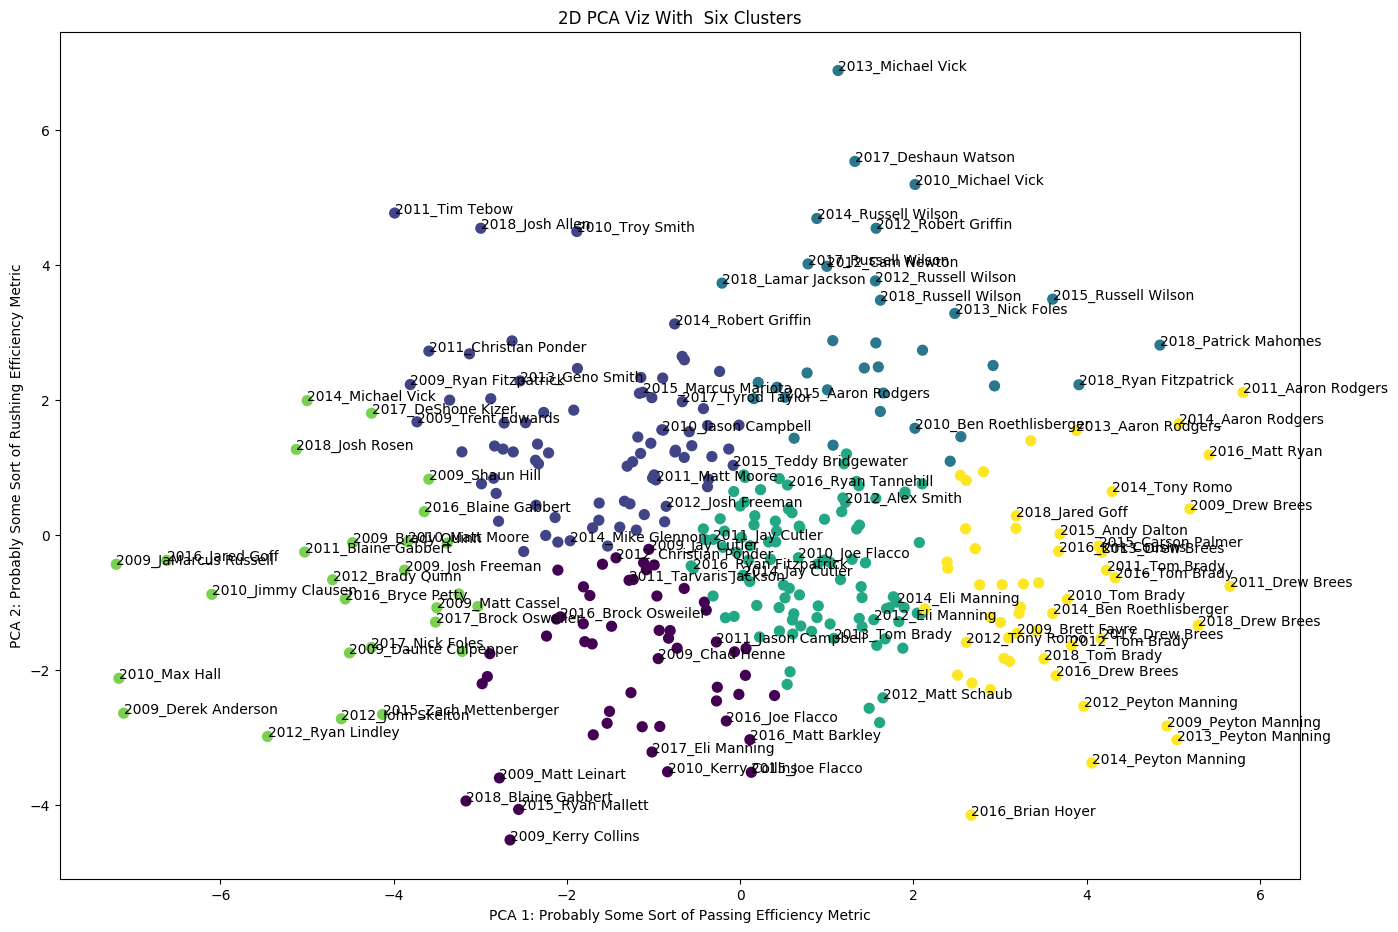

In [25]:
from sklearn.cluster import KMeans,DBSCAN
import random

plt.rcParams.update(plt.rcParamsDefault)
fig, ax = plt.subplots(figsize=(16, 11))

pca_df['pc1'] = pca_df['pc1'] * -1

X = pca_df[['pc1','pc2']].values

x = pca_df.pc1.values
y = pca_df.pc2.values
n = pca_df.label.values

# clusters = DBSCAN(eps=0.6, min_samples=5).fit_predict(X)
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
clusters = kmeans.predict(X)

print(X.shape)
plt.scatter(X[:, 0], X[:, 1], c=clusters, s=50, cmap='viridis')

for i, txt in enumerate(n):
    if ((x[i] >= 3.5) | (x[i] <=-3.5)):
        ax.annotate(txt, (x[i], y[i]))
    elif ((y[i] >= 3) | (y[i] <= -3)):
        ax.annotate(txt, (x[i], y[i]))
    # label some randoms in the middle
    elif ((x[i] <= 3.5) & (x[i] >=-3.5) & (y[i] <= 3) & (y[i] >= -3)):
        if random.random() < 0.1:
            ax.annotate(txt, (x[i], y[i]))
        
# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

ax.set_title('2D PCA Viz With  Six Clusters')
ax.set_xlabel('PCA 1: Probably Some Sort of Passing Efficiency Metric')
ax.set_ylabel('PCA 2: Probably Some Sort of Rushing Efficiency Metric')

fig.savefig('./plots/QB_2D.png', bbox_inches='tight')

In [37]:
tb12 = pca_df.loc[pca_df['name']=='Tom Brady']

rfmagic = pca_df.loc[pca_df['name']=='Ryan Fitzpatrick']

papa_johns = pca_df.loc[pca_df['name']=='Peyton Manning']

In [26]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.animation as animation

#BUILD THE ANIMATION, THIS WILL SAVE IT TO A MP4 FILE IN YOUR CURRENT DIRECTORY
def build_animation(df):
    x = [[] for i in range(10)]
    for i,j in zip(range(10), range(2009,2019)):
        x[i].append(df[df['season']==j]['epa'].values.tolist())
        
    y = [[] for i in range(10)]
    for i,j in zip(range(10), range(2009,2019)):
        y[i].append(df[df['season']==j]['success'].values.tolist())

    seasons = list(range(2009,2019))

    #DRAW THE FIGURE FIRST
    fig, ax = plt.subplots(figsize=(10,10))
    #ax.set_title('Success Rate vs. EPA/Play',{"fontsize":24})
    plt.title('data from nflscrapR',fontsize=16)
    plt.suptitle('Success Rate vs. EPA/Play',fontsize=24, y=0.945)
    ax.set_xlabel('Success Rate',{"fontsize":18})
    ax.set_ylabel('EPA/Play',{"fontsize":18})
    
    
    
    

In [27]:
#ANIMATE OVER THE YEARS
def animate(i):
    ax.clear()
    plt.xlim(-0.3,0.3)
    plt.ylim(0.3,0.6)
#     def getImage(path): 
#         return OffsetImage(plt.imread(path))

#     logos = os.listdir(os.getcwd()+'\\logos')
#     logolist = []
#     for l in logos:
#         logolist.append(os.getcwd()+'\\logos\\'+l)

    x_scatter = x[i][0]
    y_scatter = y[i][0]

    #fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(x_scatter, y_scatter, s=0.1)
    #ax.set_title('Success Rate vs. EPA/Play',{"fontsize":24})
    plt.title('data from nflscrapR',fontsize=16)
    ax.set_xlabel('Success Rate',{"fontsize":18})
    ax.set_ylabel('EPA/Play',{"fontsize":18})
    ax.text(-0.29,0.59, str(seasons[i]) + '-' + str(seasons[i]+1) + ' Season', fontsize=14)

    for x0, y0, path in zip(x_scatter, y_scatter, logolist):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=4)
        ax.add_artist(ab)
            
    ani = animation.FuncAnimation(fig, animate, frames=10, interval=2500)
    #plt.show()

    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)
    ani.save('animated_scatter.mp4', writer=writer)

# ## group by team and season, avg epa and success rate
agg = df.groupby(['sea_id'])[['epa','success']].mean().reset_index()

# #FIRST LETS MAKE IT JUST FOR 2018
agg18 = agg[agg['season']==2018]

#builds the standalone 2018 plot
build_first_plot(agg18)

#builds the animation
build_animation(agg)

KeyError: 'sea_id'